In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
import seaborn as sb

# Data observation

## CSV Data

In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

In [3]:
df_train = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
df_test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
df_data_dict = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv")

In [4]:
df_train.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST'

In [5]:
print(f"Features size (Test): {len(df_test.columns)}")
print(f"Features size (Train): {len(df_train.columns)}")
print('-' * 20)
print(f"{'Features':<100}{'Test':<10}{'Train':<10}")
for i in range(len(df_train.columns) - 1):
    test_column_status = "Yes" if (df_train.columns[i] in df_test.columns) else "---"
    train_column_status = "Yes"
    attribute = f"{df_train.columns[i]}"
    print(f"{attribute:<100}{test_column_status:<10}{train_column_status:<10}")

Features size (Test): 59
Features size (Train): 82
--------------------
Features                                                                                            Test      Train     
id                                                                                                  Yes       Yes       
Basic_Demos-Enroll_Season                                                                           Yes       Yes       
Basic_Demos-Age                                                                                     Yes       Yes       
Basic_Demos-Sex                                                                                     Yes       Yes       
CGAS-Season                                                                                         Yes       Yes       
CGAS-CGAS_Score                                                                                     Yes       Yes       
Physical-Season                                                                  

In [6]:
unlabeled = df_train['sii'].isna().sum()
print(f"Unlabeled Data / Total = {unlabeled} / {len(df_train['sii'])}")

Unlabeled Data / Total = 1224 / 3960


In [7]:
# label distribution
df_train['sii'].value_counts()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

## Parquet Data

In [8]:
ts_df = pd.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=01085eb3', engine='pyarrow')

In [9]:
ts_df

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.294667,0.307097,-1.022549,0.307828,-60.737103,0.0,28.000000,4184.000000,58680000000000,2,4,39.0
1,1,-0.121981,0.903011,-0.297953,0.195007,-13.897434,0.0,89.199997,4183.666504,58685000000000,2,4,39.0
2,2,0.014177,0.981547,-0.157197,0.039010,-9.371251,0.0,80.800003,4183.333496,58690000000000,2,4,39.0
3,3,-0.165815,0.754831,0.580785,0.099852,36.823677,0.0,9.500000,4183.000000,58695000000000,2,4,39.0
4,4,-0.401472,-0.326161,0.702366,0.058624,48.882442,0.0,1.666667,4182.666504,58700000000000,2,4,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
370951,370951,0.184817,0.013651,0.998449,0.015514,79.541451,1.0,2.500000,3098.833252,12635000000000,3,4,61.0
370952,370952,0.184298,0.013729,0.998748,0.015714,79.568062,1.0,2.500000,3098.666748,12640000000000,3,4,61.0
370953,370953,0.184778,0.013651,0.998761,0.015821,79.566879,1.0,2.500000,3098.500000,12645000000000,3,4,61.0
370954,370954,0.184635,0.013414,0.998501,0.015528,79.554039,1.0,2.500000,3098.333252,12650000000000,3,4,61.0


Text(0, 0.5, 'X')

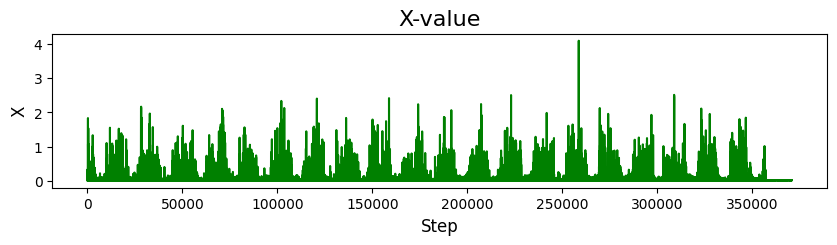

In [10]:
plt.figure(figsize=(10, 2)) 
plt.plot(ts_df['step'], ts_df['enmo'], color='g')
plt.title('X-value', fontsize=16)
plt.xlabel('Step', fontsize=12)
plt.ylabel('X', fontsize=12)

# Data Processing

In [11]:
is_aggregated = False
is_derived = True
is_removed_week_correlation = True
weak_correlation_threshold = 0.07
dropped_columns = ['id', 'SDS-SDS_Total_T']

## CSV

In [12]:
df_train = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
df_test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
df_data_dict = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv")

In [13]:
# Remove unlabeled data
df_train = df_train.dropna(subset=['sii'])

# Drop columns > 50% Nan
reliable_columns = df_train.columns[df_train.isna().mean() < 0.5]
df_train = df_train[reliable_columns]

# Get the common columns with test
# common_columns = df_train.columns.intersection(df_test.columns)
# df_train = df_train[common_columns]

# df_train_x = df_train

In [14]:
df_train.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Diastolic_BP',
       'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-Season',
       'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone',
       'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone',
       'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total', 'PCIAT-Season',
       'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04',
       'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_

## Parquet

In [15]:
train_parquet_dir = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/'
test_parquet_dir = '/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/'

ts_df = pd.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=01085eb3', engine='pyarrow')
ts_columns = ts_df.drop(columns=['step', 'time_of_day', 'weekday', 'quarter']).columns

In [16]:
def aggregate_row(row, parquet_dir, ts_columns):
    parquet_file_path = os.path.join(train_parquet_dir, f"id={row['id']}", "part-0.parquet")
    if os.path.exists(parquet_file_path):
        ts_df = pd.read_parquet(parquet_file_path, engine='pyarrow')
        ts_df_mean = ts_df.mean()[ts_columns]
        return pd.concat([row, ts_df_mean], axis=0)
    else:
        tf_df_miss = pd.Series([-1] * (len(ts_columns)), index=ts_columns)
        return pd.concat([row, tf_df_miss], axis=0)


In [17]:
if is_aggregated:
    aggregated_train = [aggregate_row(row, train_parquet_dir, ts_columns) for _, row in df_train.iterrows()]
    aggregated_test = [aggregate_row(row, test_parquet_dir, ts_columns) for _, row in df_test.iterrows()]
else:
    aggregated_train = df_train
    aggregated_test = df_test

In [18]:
df_aggregated_test = pd.DataFrame(aggregated_test)
df_aggregated_train = pd.DataFrame(aggregated_train)

In [19]:
if is_derived:
    # df_aggregated_train['Derived_BMI__'] = df_aggregated_train['Physical-Weight'] / (df_aggregated_train['Physical-Height'] / 100)**2
    # df_aggregated_test['Derived_BMI__'] = df_aggregated_test['Physical-Weight'] / (df_aggregated_test['Physical-Height'] / 100)**2

    df_aggregated_train['Pulse_Pressure__'] = df_aggregated_train['Physical-Systolic_BP'] - df_aggregated_train['Physical-Diastolic_BP']
    df_aggregated_test['Pulse_Pressure__'] = df_aggregated_test['Physical-Systolic_BP'] - df_aggregated_test['Physical-Diastolic_BP']

    df_aggregated_train['Fat_Muscle_Ratio__'] = df_aggregated_train['BIA-BIA_Fat'] / df_aggregated_train['BIA-BIA_LDM']
    df_aggregated_test['Fat_Muscle_Ratio__'] = df_aggregated_test['BIA-BIA_Fat'] / df_aggregated_test['BIA-BIA_LDM']

    df_aggregated_train['Weight_Height_Ratio__'] = df_aggregated_train['Physical-Weight'] / df_aggregated_train['Physical-Height']
    df_aggregated_test['Weight_Height_Ratio__'] = df_aggregated_test['Physical-Weight'] / df_aggregated_test['Physical-Height']


In [20]:
season_cols = [
    'Basic_Demos-Enroll_Season',
    'CGAS-Season', 
    'Physical-Season',
    'Fitness_Endurance-Season',
    'FGC-Season',
    'BIA-Season',
    'PAQ_A-Season', 
    'PAQ_C-Season',
    'PCIAT-Season', 
    'SDS-Season',
    'PreInt_EduHx-Season',
]
# Create a mapping dictionary for seasons
season_mapping = {
    'Spring': 0,
    'Summer': 1,
    'Fall': 2,
    'Winter': 3
}

# Apply manual encoding to the categorical columns
def seasonMapping(dataframe):
    pd.set_option('future.no_silent_downcasting', True)
    for col in season_cols:
        if col in dataframe.columns:
            dataframe[col] = dataframe[col].replace(season_mapping)
            dataframe[col] = dataframe[col].astype(int)

In [21]:
df_aggregated_train = df_aggregated_train.fillna(-1)
seasonMapping(df_aggregated_train)
df_aggregated_train = df_aggregated_train.drop(columns=dropped_columns)

In [22]:
df_aggregated_test = df_aggregated_test.fillna(-1)
seasonMapping(df_aggregated_test)
df_aggregated_test = df_aggregated_test.drop(columns=dropped_columns)

In [23]:
# Filter weak correlated features
pd.set_option('display.max_rows', None)
print(df_aggregated_train.corr()['sii'])

if is_removed_week_correlation:
    strong_correlated_columns = df_aggregated_train.columns[np.abs(df_aggregated_train.corr()['sii']) > weak_correlation_threshold]
    df_aggregated_train = df_aggregated_train[strong_correlated_columns]
    
pd.set_option('display.max_rows', 10)



Basic_Demos-Enroll_Season                 0.038949
Basic_Demos-Age                           0.365990
Basic_Demos-Sex                          -0.100148
CGAS-Season                              -0.012013
CGAS-CGAS_Score                          -0.029023
Physical-Season                           0.026561
Physical-BMI                              0.154942
Physical-Height                           0.168196
Physical-Weight                           0.284889
Physical-Diastolic_BP                     0.046329
Physical-HeartRate                        0.013321
Physical-Systolic_BP                      0.077139
FGC-Season                               -0.028249
FGC-FGC_CU                                0.152030
FGC-FGC_CU_Zone                          -0.044882
FGC-FGC_PU                                0.105840
FGC-FGC_PU_Zone                          -0.018666
FGC-FGC_SRL                              -0.059390
FGC-FGC_SRL_Zone                         -0.075180
FGC-FGC_SRR                    

In [24]:
# df_aggregated_train = df_train
# df_aggregated_train = df_aggregated_train.fillna(0) # comment
# df_aggregated_test = df_test

#-------
label = df_aggregated_train['sii']
label

0       2.0
1       0.0
2       0.0
3       1.0
5       1.0
       ... 
3953    0.0
3954    1.0
3955    1.0
3957    1.0
3958    0.0
Name: sii, Length: 2736, dtype: float64

In [25]:
common_columns = df_aggregated_train.columns.intersection(df_aggregated_test.columns)
df_aggregated_train = df_aggregated_train[common_columns]
df_aggregated_test = df_aggregated_test[common_columns]

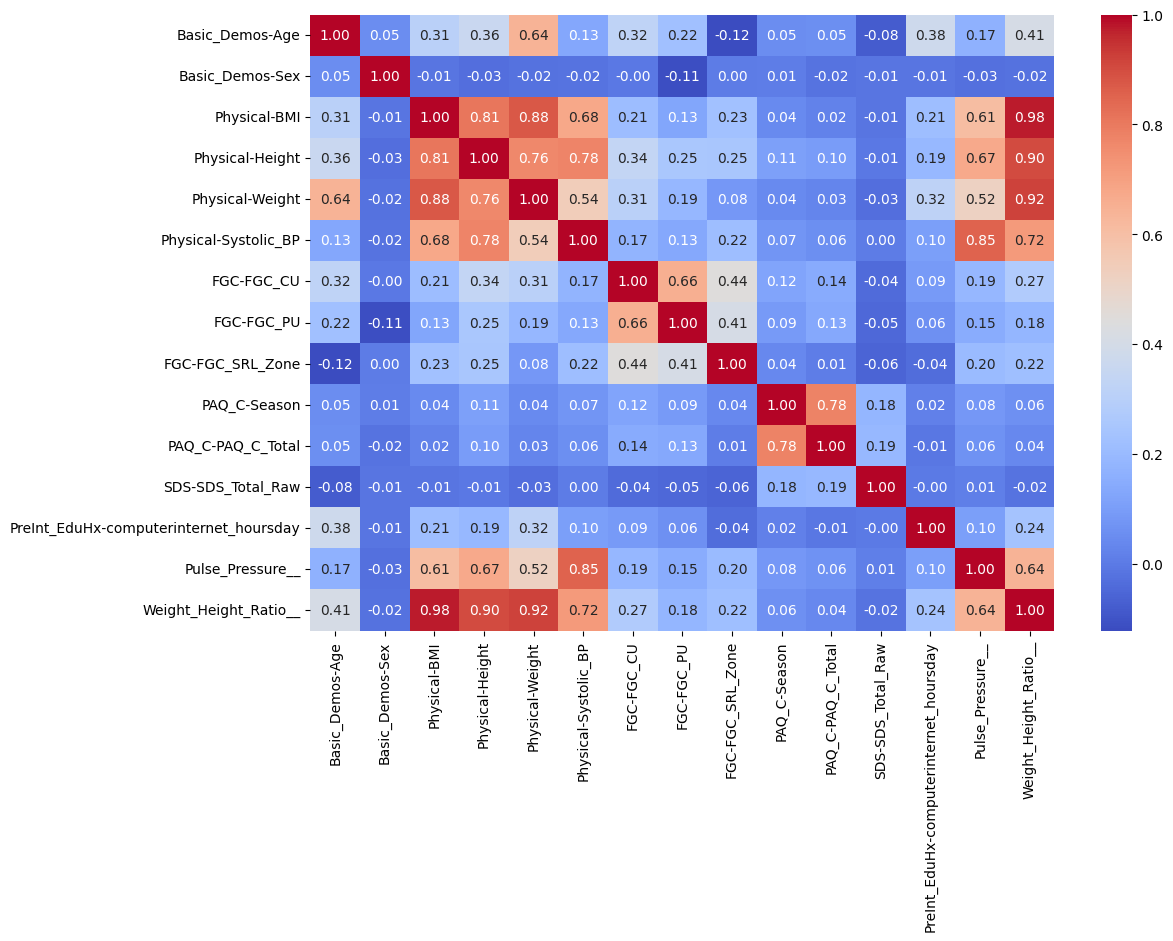

In [26]:
corr_matrix = df_aggregated_train.corr()
plt.figure(figsize=(12, 8))  # Adjust the figure size (width, height)
sb.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [27]:
df_aggregated_train

,Basic_Demos-Age,Basic_Demos-Sex,Physical-BMI,Physical-Height,Physical-Weight,Physical-Systolic_BP,FGC-FGC_CU,FGC-FGC_PU,FGC-FGC_SRL_Zone,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,PreInt_EduHx-computerinternet_hoursday,Pulse_Pressure__,Weight_Height_Ratio__
0,5,0,16.877316,46.0,50.8,-1.0,0.0,0.0,0.0,-1,-1.000,-1.0,3.0,-1.0,1.104348
1,9,0,14.035590,48.0,46.0,122.0,3.0,5.0,1.0,2,2.340,46.0,0.0,47.0,0.958333
2,10,1,16.648696,56.5,75.6,117.0,20.0,7.0,1.0,1,2.170,38.0,2.0,52.0,1.338053
3,9,0,18.292347,56.0,81.6,117.0,18.0,5.0,0.0,3,2.451,31.0,0.0,57.0,1.457143
5,13,1,22.279952,59.5,112.2,102.0,12.0,6.0,1.0,0,4.110,40.0,0.0,42.0,1.885714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,8,0,17.139810,52.5,67.2,112.0,0.0,0.0,1.0,2,3.440,41.0,2.0,52.0,1.280000
3954,7,1,13.927006,48.5,46.6,105.0,0.0,0.0,0.0,-1,-1.000,48.0,0.0,40.0,0.960825
3955,13,0,16.362460,59.5,82.4,104.0,16.0,10.0,1.0,3,3.260,35.0,1.0,33.0,1.384874
3957,11,0,21.441500,60.0,109.8,116.0,15.0,0.0,1.0,3,2.729,56.0,0.0,37.0,1.830000


In [28]:
df_aggregated_test

,Basic_Demos-Age,Basic_Demos-Sex,Physical-BMI,Physical-Height,Physical-Weight,Physical-Systolic_BP,FGC-FGC_CU,FGC-FGC_PU,FGC-FGC_SRL_Zone,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,PreInt_EduHx-computerinternet_hoursday,Pulse_Pressure__,Weight_Height_Ratio__
0,5,0,16.877316,46.0,50.8,-1.0,0.0,0.0,0.0,-1,-1.000,-1.0,3.0,-1.0,1.104348
1,9,0,14.035590,48.0,46.0,122.0,3.0,5.0,1.0,2,2.340,46.0,0.0,47.0,0.958333
2,10,1,16.648696,56.5,75.6,117.0,20.0,7.0,1.0,1,2.170,38.0,2.0,52.0,1.338053
3,9,0,18.292347,56.0,81.6,117.0,18.0,5.0,0.0,3,2.451,31.0,0.0,57.0,1.457143
4,18,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.000,-1.0,-1.0,-1.0,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,7,0,29.315775,54.0,121.6,99.0,6.0,0.0,1.0,-1,-1.000,35.0,2.0,19.0,2.251852
16,5,1,17.284504,44.0,47.6,109.0,0.0,0.0,1.0,-1,-1.000,37.0,0.0,48.0,1.081818
17,10,1,19.893157,55.0,85.6,-1.0,5.0,0.0,0.0,-1,-1.000,-1.0,1.0,-1.0,1.556364
18,6,0,30.094649,37.5,60.2,95.0,6.0,0.0,0.0,-1,-1.000,39.0,3.0,34.0,1.605333


# Model Training

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_aggregated_train, label, test_size=0.2, random_state=2)

In [30]:
# Feature Scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [31]:
# Apply PCA
# pca = PCA(n_components=0.95)  # Keep 95% of the variance
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

## Random Forest

In [32]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, 
                                  max_depth=10, 
                                  min_samples_split=10, 
                                  min_samples_leaf=4)
rf_model.fit(X_train, y_train)

param_grid = {
    'max_depth': [8, 10, 12]  # Experiment with different depths
}

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best max_depth:", grid_search.best_params_['max_depth'])

Best max_depth: 8


In [33]:
best_rf_model = grid_search.best_estimator_
# best_rf_model

## XGBoost

In [34]:
# XGBoost_model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
# XGBoost_model.fit(X_train, y_train)

## LightGBM

In [35]:
# LGBM_model = LGBMClassifier(n_estimators=100, max_depth=-1, learning_rate=0.1, random_state=42)
# LGBM_model.fit(X_train, y_train)

## CatBoost

In [36]:
# CatBoost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0)
# CatBoost_model.fit(X_train, y_train)

## Model Ensemble

# Model Evaluation

In [37]:
# Random Forest
y_pred = best_rf_model.predict(X_test)

# XGBoost
# y_pred = XGBoost_model.predict(X_test)

# LightGBM
# y_pred = LGBM_model.predict(X_test)

# CatBoost
# y_pred = CatBoost_model.predict(X_test)

# Model Ensemble
#y_pred = ensemble_model.predict(X_test)

In [38]:
print(classification_report(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.92      0.64      0.75       450
         1.0       0.18      0.35      0.24        79
         2.0       0.10      0.42      0.17        19
         3.0       0.00      0.00      0.00         0

    accuracy                           0.59       548
   macro avg       0.30      0.35      0.29       548
weighted avg       0.79      0.59      0.66       548

[[287 117  45   1]
 [ 22  28  24   5]
 [  3   7   8   1]
 [  0   0   0   0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Submit

In [39]:
y_pred = best_rf_model.predict(df_aggregated_test)

In [40]:
df_test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
submission = pd.DataFrame({
    'id': df_test['id'],  # Include 'id' from test_data
    'sii': y_pred  # Predictions from the model
})
print(submission.head())

         id  sii
0  00008ff9  0.0
1  000fd460  0.0
2  00105258  0.0
3  00115b9f  0.0
4  0016bb22  0.0


In [41]:
df = submission.to_csv('submission.csv', index=False)

In [42]:
submission['sii'].value_counts()

sii
0.0    19
1.0     1
Name: count, dtype: int64